In [1]:
import logging
import os
import sys

sys.path.append("..")

import gc
import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin

%matplotlib inline

LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
warnings.filterwarnings("ignore")

In [2]:
SEED = 0xBADBEEF
# GPU choosing
DEVICE_IDS = [0]
# For Colored MNIST exps
DATASET1, DATASET1_PATH = "MNIST-colored_2", "~/data/MNIST"
DATASET2, DATASET2_PATH = "MNIST-colored_3", "~/data/MNIST"
DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3


In [3]:
from datetime import datetime

# change below 3 variables to get real EXP_NAME
STRATEGY = "Adapt"  # [Normal|Fix|Adapt]
PIVOTAL_LIST = [0, 20, 50, 100]
TIME = "000000-000000" # "20240526-134124"


EXP_NAME = f"{STRATEGY}_{DATASET1}_to_{DATASET2}_pivotal_{'_'.join(map(str, PIVOTAL_LIST))}_{TIME}"
LOAD_PATH = f"../logs/{EXP_NAME}/"



print(f"{EXP_NAME = }")

LOAD_PATH = "../logs/weights/epl_1/"
print(f"{LOAD_PATH = }")


with open(os.path.join(LOAD_PATH, "config.json"), "r", encoding="utf-8") as f:
    CONFIG = json.load(f)


EXP_NAME = 'Adapt_MNIST-colored_2_to_MNIST-colored_3_pivotal_0_20_50_100_000000-000000'
LOAD_PATH = '../logs/weights/epl_1/'


In [4]:
EPSILON = CONFIG["EPSILON"]

N_STEPS = CONFIG["N_STEPS"]
BATCH_SIZE = CONFIG["BATCH_SIZE"]

PIVOTAL_LIST = CONFIG["PIVOTAL_LIST"]


BETA_NET_LR, SDE_LR = CONFIG["BETA_NET_LR"], CONFIG["SDE_LR"]
BETA_NET_BETA, SDE_BETA = CONFIG["BETA_NET_BETA"], CONFIG["SDE_BETA"]


IMG_SIZE = CONFIG["IMG_SIZE"]
UNET_BASE_FACTOR = CONFIG["UNET_BASE_FACTOR"]

TIME_DIM = CONFIG["TIME_DIM"]
USE_POSITIONAL_ENCODING = CONFIG["USE_POSITIONAL_ENCODING"]

PREDICT_SHIFT = CONFIG["PREDICT_SHIFT"]

USE_GRADIENT_CHECKPOINT = CONFIG["USE_GRADIENT_CHECKPOINT"]
N_LAST_STEPS_WITHOUT_NOISE = CONFIG["N_LAST_STEPS_WITHOUT_NOISE"]
IMAGE_INPUT = CONFIG["IMAGE_INPUT"]
FID_EPOCHS = CONFIG["FID_EPOCHS"]


assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)


### initalize data sampler


In [5]:
from src.tools import load_dataset

X_sampler, X_test_sampler = load_dataset(
    DATASET1,
    DATASET1_PATH,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=1,
)
Y_sampler, Y_test_sampler = load_dataset(
    DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=1
)

torch.cuda.empty_cache()
gc.collect()
clear_output()

logging.info("Initialize data sampler")

### initialize models


In [6]:
from src.tools import weights_init_D

from src.cunet import CUNet
from src.enot import SDE
from src.resnet2 import ResNet_D

SDEs, BETA_NETs = [], []
SDE_OPTs, BETA_NET_OPTs = [], []
SDE_SCHEDULERs, BETA_NET_SCHEDULERs = [], []

for i in range(len(PIVOTAL_LIST) * 2 - 2):
    sde = CUNet(
        DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    sde = SDE(
        shift_model=sde,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=IMAGE_INPUT,
    ).cuda()
    SDEs.append(sde)

    beta_net = ResNet_D(IMG_SIZE, nc=DATASET2_CHANNELS).cuda()
    beta_net.apply(weights_init_D)
    BETA_NETs.append(beta_net)

    sde_opt = torch.optim.Adam(
        sde.parameters(), lr=SDE_LR, weight_decay=1e-10, betas=(SDE_BETA, 0.999)
    )
    beta_net_opt = torch.optim.Adam(
        beta_net.parameters(),
        lr=BETA_NET_LR,
        weight_decay=1e-10,
        betas=(BETA_NET_BETA, 0.999),
    )
    SDE_OPTs.append(sde_opt)
    BETA_NET_OPTs.append(beta_net_opt)

    sde_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        sde_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    beta_net_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        beta_net_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    SDE_SCHEDULERs.append(sde_scheduler)
    BETA_NET_SCHEDULERs.append(beta_net_scheduler)


if len(DEVICE_IDS) > 1:
    for i in range(len(SDEs)):
        SDEs[i] = nn.DataParallel(SDEs[i], device_ids=DEVICE_IDS)
        BETA_NETs[i] = nn.DataParallel(BETA_NETs[i], device_ids=DEVICE_IDS)

        print("T params:", np.sum([np.prod(p.shape) for p in SDEs[0].parameters()]))
        print(
            "D params:", np.sum([np.prod(p.shape) for p in BETA_NETs[0].parameters()])
        )

#### load weights


In [7]:
# CKPT_DIR = os.path.join(LOAD_PATH, "iter5000/")
CKPT_DIR = LOAD_PATH
for i, sde in enumerate(SDEs):
    path = os.path.join(CKPT_DIR, f"sde{i}.pt")
    print(f"{path = }")
    sde.load_state_dict(torch.load(path))

path = '../logs/weights/epl_1/sde0.pt'
path = '../logs/weights/epl_1/sde1.pt'
path = '../logs/weights/epl_1/sde2.pt'
path = '../logs/weights/epl_1/sde3.pt'
path = '../logs/weights/epl_1/sde4.pt'
path = '../logs/weights/epl_1/sde5.pt'


### trans example


In [8]:
from src import distributions


@torch.no_grad()
def draw_linked_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    SDEs: list[SDE],
    plot_n_samples: int = 4,
):
    device = next(SDEs[0].parameters()).device
    source_dataset, target_dataset, mapped_dataset = [], [], []
    pivotals_list = []
    for i in range(plot_n_samples):
        source, target = (
            source_sampler.sample(1).to(device),
            target_sampler.sample(1).to(device),
        )

        pivotals = [source.clone().detach()]
        for t in range(len(SDEs)):
            x0 = pivotals[t]
            trajectory, times, _ = SDEs[t](x0)
            xN = trajectory[:, -1, :]
            pivotals.append(xN)

        mapped_dataset.append(pivotals[-1])
        source_dataset.append(source)
        target_dataset.append(target)

        pivotals.append(target.clone().detach())
        pivotals_list.append(pivotals)

        fig, axes = plt.subplots(1, len(SDEs) + 2, figsize=(5 * (len(SDEs) + 2), 5))
        axes = axes.flatten()
        for pivotal, ax in zip(pivotals, axes):
            img = torch.squeeze(pivotal).to("cpu")
            img = img.permute(1, 2, 0).mul(0.5).add(0.5).numpy().clip(0, 1)
            ax.imshow(img)

        fig.tight_layout(pad=0.001)

    plt.show()

    torch.cuda.empty_cache()
    gc.collect()

    return pivotals_list

In [9]:
EPSILON

1

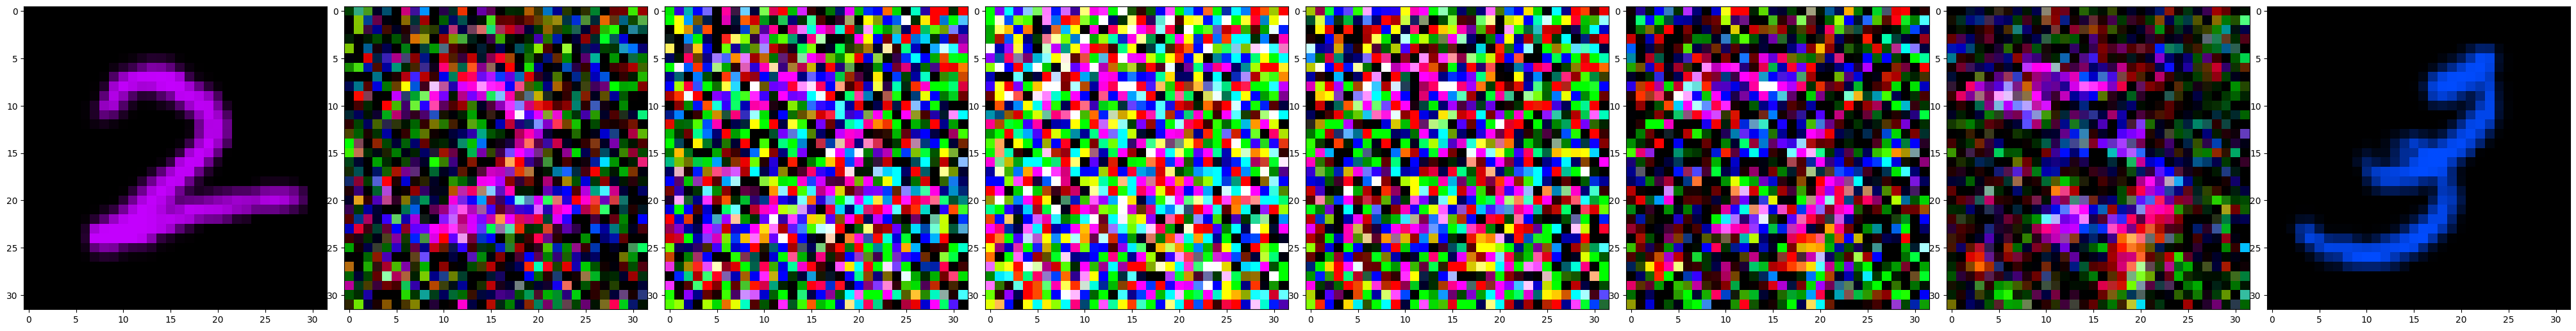

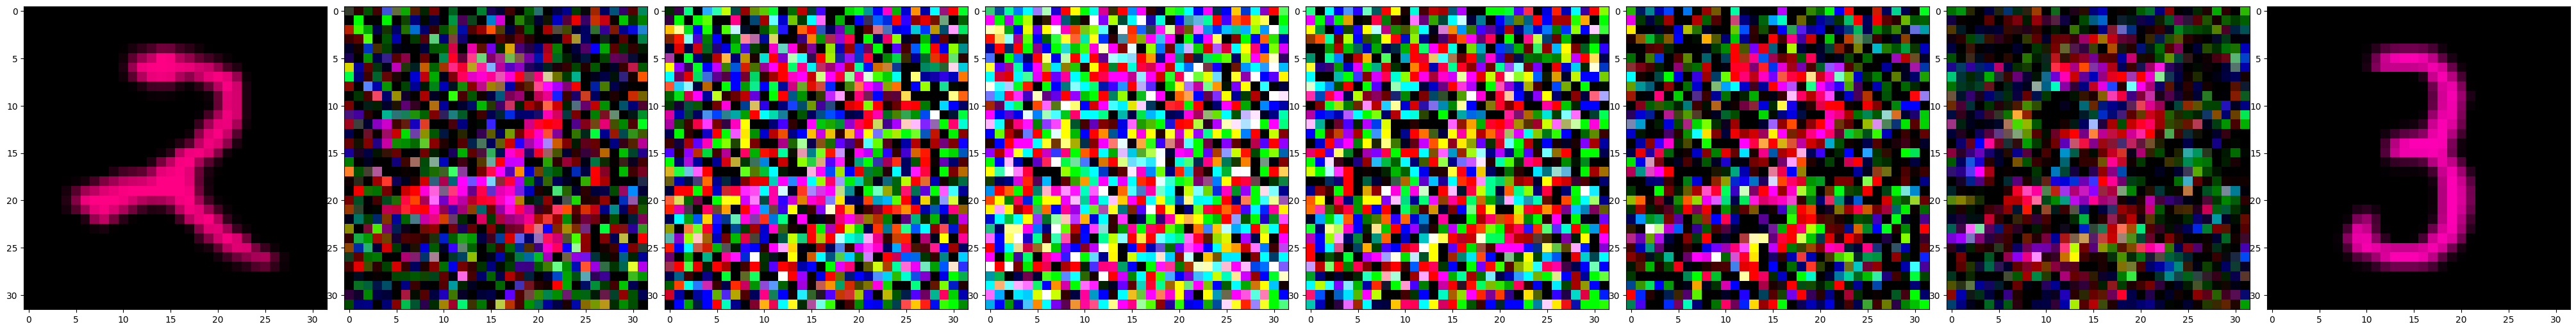

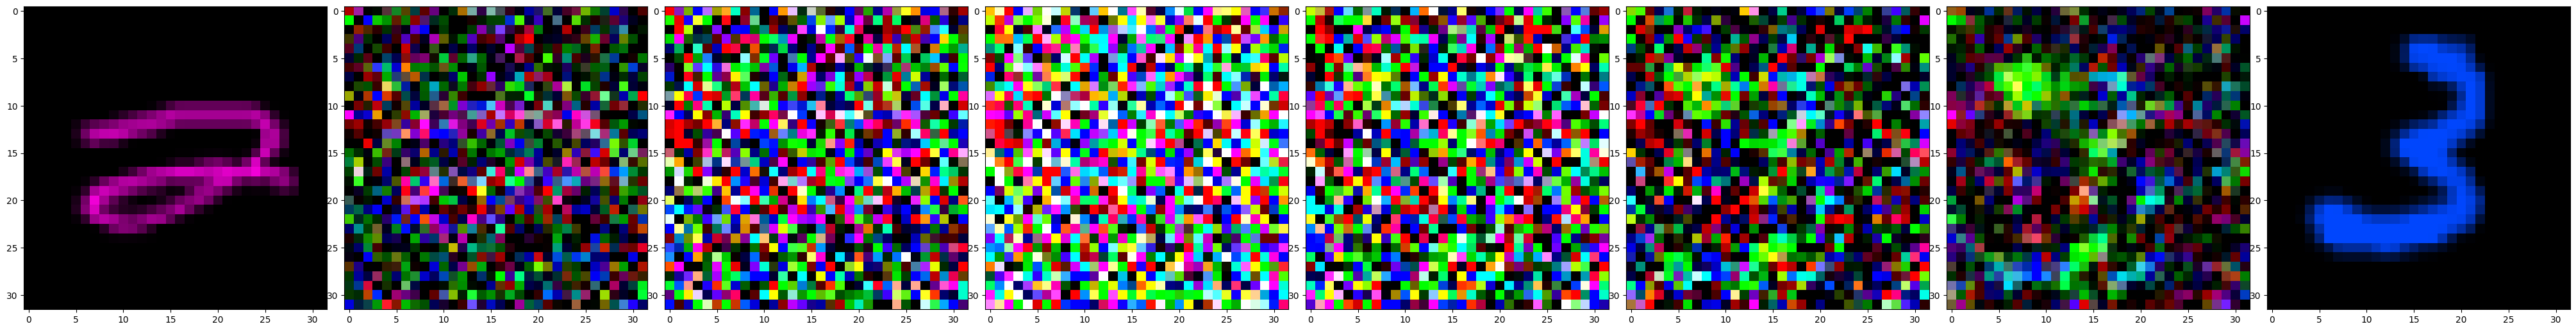

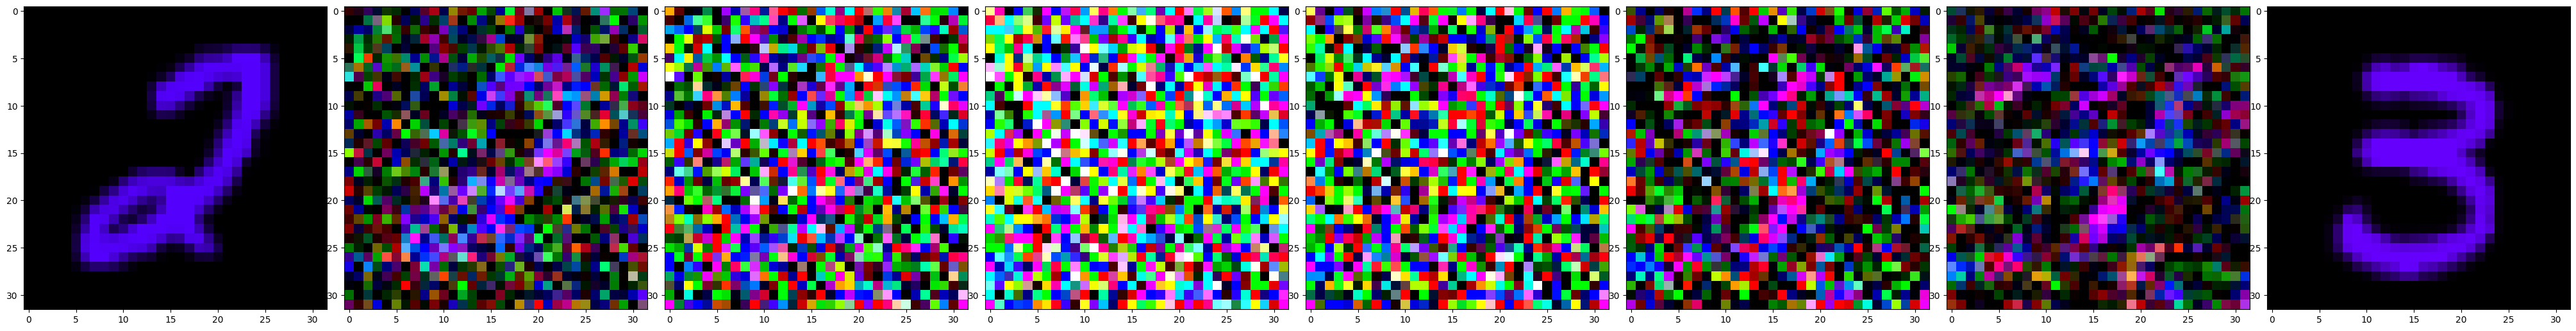

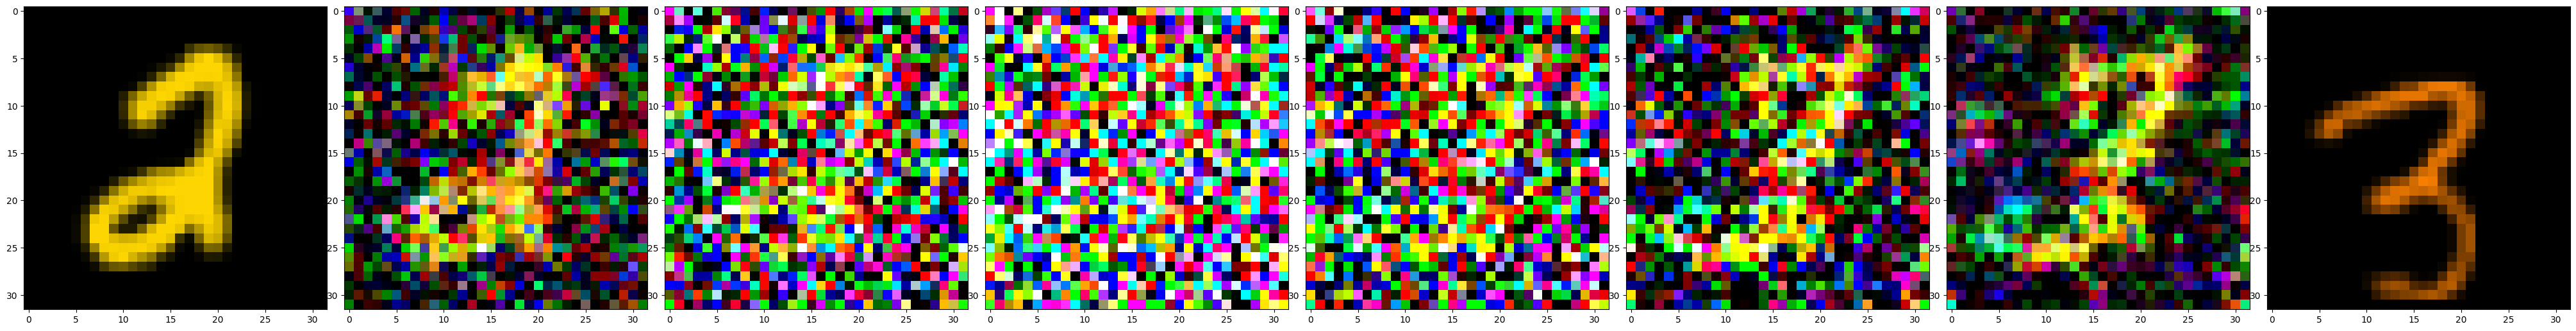

In [10]:
# pivotals_list shape (plot_n_samples, n_steps, (RGB image))
pivotals_list = draw_linked_mapping(
    X_sampler,
    Y_sampler,
    SDEs,
    plot_n_samples=5,
)

In [10]:
# for pivotals in pivotals_list:
#     fig, axes = plt.subplots(1, 8, figsize=(40, 5))
#     axes = axes.flatten()
#     for pivotal, ax in zip(pivotals, axes):
#         img = torch.squeeze(pivotal).to("cpu")
#         img = img.permute(1, 2, 0).mul(0.5).add(0.5).numpy().clip(0, 1)
#         ax.imshow(img)

### FID


#### load FID stats

should run ../../stats/compute_stats.ipynb to get stats json file first


In [24]:
filename = "../stats/{}_{}_test.json".format(DATASET2, IMG_SIZE)
with open(filename, "r") as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats["mu"], data_stats["sigma"]
del data_stats

#### Calculate FID


In [14]:
from src.fid_score import calculate_frechet_distance
from src.tools import get_linked_sdes_pushed_loader_stats

print("Computing FID")
mu, sigma = get_linked_sdes_pushed_loader_stats(
    SDEs, X_test_sampler.loader, n_epochs=FID_EPOCHS, batch_size=BATCH_SIZE
)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)

Computing FID


In [15]:
print(f"{fid = }")

fid = 41.630040873129474


## exp result logs

|Strategy|P List|Iteration|EPSILON|FID|
|---|---|---|---|---|
|Fix | 0 50 100 | 2000 | 0 | 32.893237846423915 |
|Adapt | 0 50 100 | 2000 | 0 | 46.39155850464904 |
|Fix | 0 50 100 | 5000 | 0 | 38.80040275352846 |
|Adapt | 0 20 50 100 | 2000 | 0 | 41.630040873129474|

### ACC

TODO:
